In [1]:
import torch as th
import torch.nn.functional as th_f
import torchaudio as th_audio
import torchaudio.functional as th_audio_f

import torch_scatter

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
wav_path = "/home/samuel/Téléchargements/06 D'yer Mak'er.wav"

In [3]:
raw_audio, _ = th_audio.load(wav_path)

In [4]:
raw_audio_mono = raw_audio.mean(0)[:44100 * 30]

In [5]:
nperseg = 2 ** 12

stride = 2 ** 8

In [6]:
print(nperseg)
print(stride)

4096
256


In [7]:
hann_window = th.hann_window(nperseg)

complex_values = th_audio_f.spectrogram(
    raw_audio_mono,
    pad=0, window=hann_window,
    n_fft=nperseg, hop_length=stride, win_length=nperseg,
    power=None, normalized=True,
    return_complex=True
)

In [8]:
complex_values.size()

torch.Size([2049, 5168])

In [9]:
complex_without_nyquist = complex_values[:-1, :]

In [10]:
magn = th.abs(complex_without_nyquist)
phase = th.angle(complex_without_nyquist)

In [11]:
def diff(x: th.Tensor) -> th.Tensor:
    """

    :param x:
    :type x:
    :return:
    :rtype:
    """
    return th_f.pad(x[1:, :] - x[:-1, :], (0, 0, 1, 0), "constant", 0)


def unwrap(phi: th.Tensor) -> th.Tensor:
    """

    :param phi:
    :type phi:
    :return:
    :rtype:
    """
    dphi = diff(phi)
    dphi_m = ((dphi + np.pi) % (2 * np.pi)) - np.pi
    dphi_m[(dphi_m == -np.pi) & (dphi > 0)] = np.pi
    phi_adj = dphi_m - dphi
    phi_adj[dphi.abs() < np.pi] = 0
    return phi + phi_adj.cumsum(0)

In [12]:
phase = unwrap(phase)
phase = phase[:, 1:] - phase[:, :-1]

magn = magn[:, 1:]

In [13]:
n_bins = magn.size()[0]

required_length = 512

# Mel

In [14]:
min_hz = 0.
max_hz = 44100 // 2

In [15]:
def hz2mel(hz):
    return 2595. * th.log(th.tensor(1.) + hz / 700.) / th.log(th.tensor(10.))

def mel2hz(erb):
    return (10. ** (erb / 2595.) - 1.) * 700.

In [16]:
min_mel = hz2mel(th.tensor(min_hz))
max_mel = hz2mel(th.tensor(max_hz))

In [17]:
min_mel, max_mel

(tensor(0.), tensor(3923.3374))

In [18]:
bucket_boundaries = mel2hz(th.linspace(min_mel, max_mel, required_length))

# ERB

In [19]:
min_hz = 0.
max_hz = 44100 // 2

In [20]:
def hz2erb(hz):
    return 21.4 * th.log(th.tensor(1.) + 0.00437 * hz) / th.log(th.tensor(10.))

def erb2hz(erb):
    return (10. ** (erb / 21.4) - 1.) / 0.00437

In [21]:
min_erb = hz2erb(th.tensor(min_hz))
max_erb = hz2erb(th.tensor(max_hz))

In [22]:
min_erb, max_erb

(tensor(0.), tensor(42.5512))

In [23]:
bucket_boundaries = erb2hz(th.linspace(min_erb, max_erb, required_length))

# Bark

In [24]:
def hz2bark(f):
        #       HZ2BARK         Converts frequencies Hertz (Hz) to Bark
        #
    b = 6 * th.arcsinh(f / 600)
    return b
    
    
def bark2hz(b):
        #       BARK2HZ         Converts frequencies Bark to Hertz (HZ)
        #
    f = 600 * th.sinh(b / 6)
    return f

In [25]:
min_hz = 0.
max_hz = 44100 // 2

In [26]:
min_bark = hz2bark(th.tensor(min_hz))
max_bark = hz2bark(th.tensor(max_hz))

In [27]:
min_bark, max_bark

(tensor(0.), tensor(25.7848))

In [28]:
bucket_boundaries = bark2hz(th.linspace(min_bark, max_bark, required_length))

In [29]:
bucket_boundaries.size()

torch.Size([512])

# Scatter

In [30]:
frequencies = th.linspace(min_hz, max_hz, n_bins)

In [31]:
buckets = th.bucketize(frequencies, bucket_boundaries)

In [32]:
#buckets_count = th.bincount(buckets) + 1

In [33]:
magn.size()

torch.Size([2048, 5167])

In [34]:
buckets.unique().size()

torch.Size([451])

In [35]:
#res = res.scatter_add_(0, buckets[:, None].repeat(1, complex_without_nyquist.size()[1]), complex_without_nyquist)

buckets_tmp = buckets[:, None].repeat(1, magn.size()[1])

magn_res = torch_scatter.scatter_mean(magn, buckets_tmp, dim=0)
phase_res = torch_scatter.scatter_mean(phase, buckets_tmp, dim=0)

In [36]:
magn_res.size()

torch.Size([512, 5167])

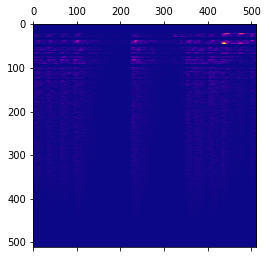

In [37]:
bl = magn_res[:, 60:60+512].numpy()

bl = bl / (bl.max() - bl.min())

plt.matshow(bl, cmap="plasma")
plt.show()

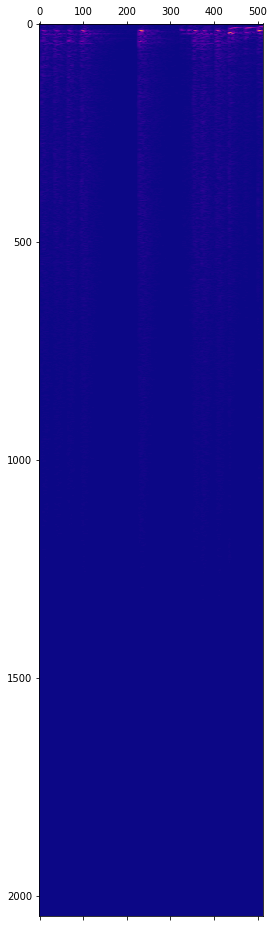

In [38]:
plt.matshow(th.abs(complex_without_nyquist[:, 60:60+512]).numpy(), cmap="plasma")
plt.show()

# Inverse

In [39]:
magn_res.size(), phase_res.size()

(torch.Size([512, 5167]), torch.Size([512, 5167]))

In [40]:
inv_magn = th.zeros(n_bins, magn_res.size()[1])
inv_phase = th.zeros(n_bins, phase_res.size()[1])

In [41]:
buckets.size()

torch.Size([2048])

In [42]:
buckets

tensor([  0,   3,   5,  ..., 511, 511, 511])

In [43]:
for i, b in enumerate(tqdm(buckets)):
    inv_magn[i, :] = magn_res[b, :]
    inv_phase[i, :] = phase_res[b, :]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:00<00:00, 72147.34it/s]


In [44]:
for i in range(inv_phase.size()[1] - 1):
    inv_phase[:, i + 1] = inv_phase[:, i + 1] + inv_phase[:, i]

inv_phase = inv_phase % (2 * np.pi)

In [45]:
z = inv_magn * th.cos(inv_phase) + inv_magn * th.sin(inv_phase) * 1j

In [46]:
z = th.cat([z, th.zeros(1, z.size()[1]) + 1j * th.zeros(1, z.size()[1])], dim=0)

In [47]:
z.size()

torch.Size([2049, 5167])

In [48]:
hann_window = th.hann_window(nperseg)

raw_audio = th_audio_f.inverse_spectrogram(
        z, length=None,
        pad=0, window=hann_window,
        n_fft=nperseg, hop_length=stride,
        win_length=nperseg, normalized=True
)

In [49]:
th_audio.save("output.wav", raw_audio[None, :], 44100)